# Basic output

In [ ]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.models import resnet50

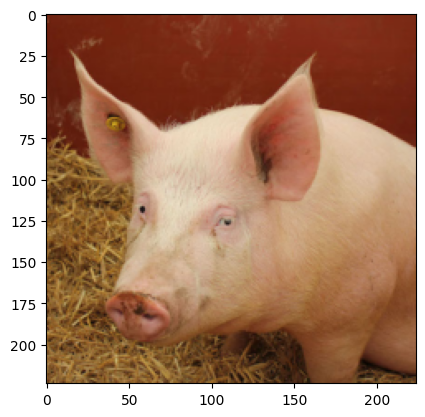

In [ ]:
# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

In [ ]:
# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [ ]:
# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 237MB/s]


In [ ]:
pred = model(norm(pig_tensor))

In [ ]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

hog


In [ ]:
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())

0.003882253309711814


# Adversarial example

maximize the loss of the correct class.

In [ ]:
import torch.optim as optim

In [ ]:
epsilon = 2./255
# Gradient of loss with respect to the pertubation (make pertubabtion small and add it to image)
# In normal way we take gradient of loss with respect to the model weights

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    # there is a restriction which it shouldn't be greater or smaller than epsilon
    delta.data.clamp_(-epsilon, epsilon)

print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

0 -0.003882253309711814
5 -0.006934741511940956
10 -0.015805913135409355
15 -0.0799558088183403
20 -11.142181396484375
25 -13.397157669067383
True class probability: 1.038025061461667e-06


In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  wombat
Predicted probability: 0.9997883439064026


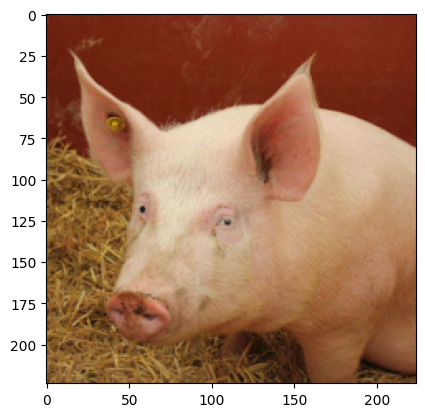

In [ ]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

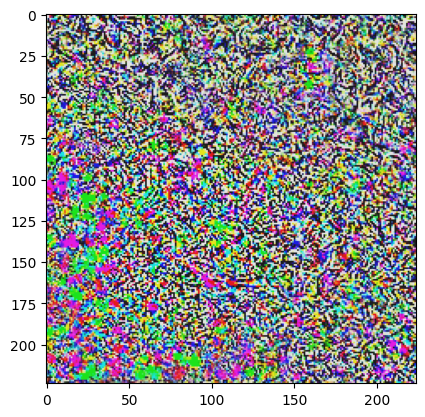

In [ ]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))


#Targeted attacks

Maximize the loss of the correct class, we maximize the loss of the correct class while also minimizing the loss of the target class.

In [ ]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) +
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 24.00604820251465
10 -0.15508747100830078
20 -7.620338439941406
30 -14.787199020385742
40 -21.15138816833496
50 -25.89435386657715
60 -30.196027755737305
70 -34.96584701538086
80 -38.666412353515625
90 -38.255027770996094


In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  airliner
Predicted probability: 0.9149457812309265


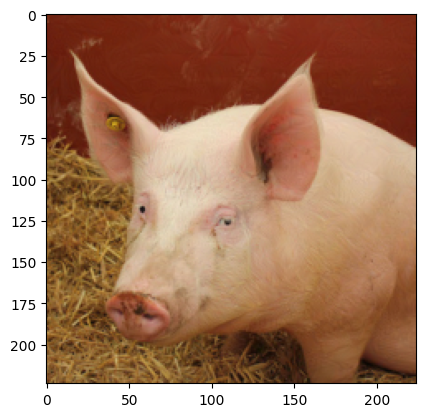

In [ ]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

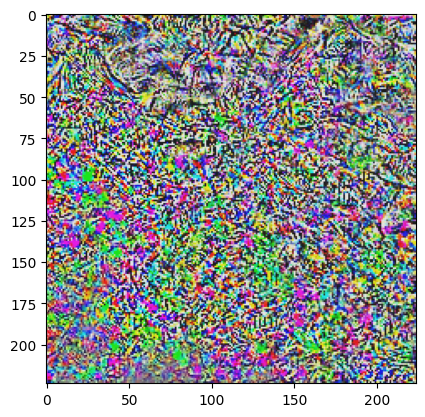

In [ ]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

# Linear models

how well traditional linear models might work to also prevent adversarial examples

In [ ]:
import numpy as np
import  matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

In [ ]:
# Filter the dataset based on labels
train_idx = mnist_train.targets <= 1  # Filter for labels 0 and 1
mnist_train.data = mnist_train.data[train_idx]
mnist_train.targets = mnist_train.targets[train_idx]

In [ ]:
# Filter the dataset based on labels
test_idx = mnist_test.targets <= 1  # Filter for labels 0 and 1
mnist_test.data = mnist_test.data[test_idx]
mnist_test.targets = mnist_test.targets[test_idx]

In [ ]:
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

In [ ]:
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [ ]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1.)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
for i in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.005211	0.015176	0.000473	0.003107
0.001421	0.005517	0.000473	0.002491
0.001105	0.004487	0.000473	0.002244
0.001105	0.003888	0.000473	0.002121
0.000947	0.003581	0.000946	0.002054
0.000869	0.003196	0.000473	0.002065
0.000790	0.003062	0.000473	0.001912
0.000790	0.002777	0.000946	0.001902
0.000869	0.002694	0.000473	0.001885
0.000711	0.002560	0.000473	0.001830


error rate of 0.0004 means 1 wrong in **test set**.

Text(0.5, 1.0, 'True Label: 0')

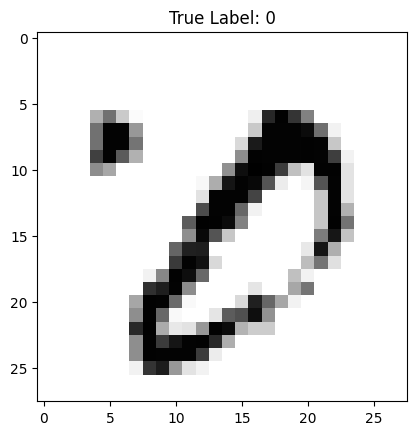

In [ ]:
X_test = (test_loader.dataset.test_data.float()/255).view(len(test_loader.dataset),-1)
y_test = test_loader.dataset.test_labels
yp = model(X_test)[:,0]
# which doesn’t depend on x, this means that the best perturbation to apply is the same across all examples.
idx = (yp > 0) * (y_test == 0) + (yp < 0) * (y_test == 1)
plt.imshow(1-X_test[idx][0].view(28,28).numpy(), cmap="gray")
plt.title("True Label: {}".format(y_test[idx].item()))

It’s perhaps not all that obvious, but if you squint you can see that maybe there is a vertical line (like a 1) in black pixels, and a cirlce (like a 0) in in white. The intuition here is that moving in the black direction, we make the classifier think the image is more like a 1, while moving in the white direction, more like a 0.

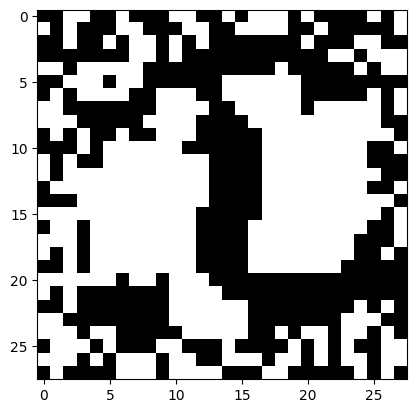

In [ ]:
epsilon = 0.2
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")

In [ ]:
def epoch_adv(loader, model, delta):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model((X-(2*y.float()[:,None,None,None]-1)*delta).view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
print(epoch_adv(test_loader, model, delta[None,None,:,:]))

(0.8401891252955083, 3.244136430411192)


From 0 error to 82.8% error rate.

(it is recognizable for humans)

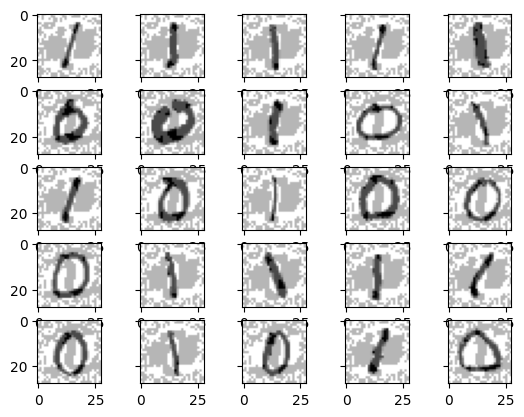

In [ ]:
f,ax = plt.subplots(5,5, sharey=True)
for i in range(25):
    ax[i%5][i//5].imshow(1-(X_test[i].view(28,28) - (2*y_test[i]-1)*delta).numpy(), cmap="gray")
    ax

Training robust linear models

ℓ∞ ball with ϵ=0.2 could easily create 100% error.

we can perform exact robust optimization by simply incorporating the ℓ1 norm into the objective.

we just subtract ϵ(2y−1) ∥w∥1 from the predictions (the 2y−1 scales the 0/1 entries to -1/+1).


In [ ]:
def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0] - epsilon*(2*y.float()-1)*model.weight.norm(1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [ ]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1e-1)
epsilon = 0.2
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(20):
    train_err, train_loss = epoch_robust(train_loader, model, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.150099	0.378674	0.064775	0.214361
0.072088	0.223172	0.051064	0.171155
0.062456	0.197316	0.043026	0.157616
0.058034	0.183975	0.042080	0.146756
0.053060	0.174692	0.037352	0.133904
0.049349	0.168052	0.036407	0.126340
0.048006	0.162762	0.038298	0.132336
0.045085	0.158190	0.034988	0.125896
0.043979	0.154651	0.029787	0.120227
0.043348	0.151618	0.026950	0.112518
0.041137	0.148967	0.028369	0.116707
0.040426	0.146734	0.028369	0.116503
0.039321	0.145077	0.026478	0.109419
0.038610	0.143331	0.027423	0.112998
0.037742	0.141624	0.026478	0.111438
0.037031	0.140321	0.027423	0.110533
0.036557	0.139209	0.025532	0.102830
0.034978	0.137967	0.024586	0.101612
0.034978	0.137135	0.024586	0.100498
0.034741	0.136232	0.023641	0.098449


no adversarial attack can lead to more then 2.5% error on the test set.

But how well does it do on the non-adversarial **training set**?

(model optimizer has been robust to adversarials)

In [ ]:
train_err, train_loss = epoch(train_loader, model)
test_err, test_loss = epoch(test_loader, model)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.006080	0.015162	0.003783	0.008162


We’re getting 0.3% error on the test set. This is good, but not as good as we were doing with standard training; we’re now making 8 mistakes on the test set, instead of the 1 that we were making before.

trade off between clean accuracy and robust accuracy, and doing better on the robust error leads to higher clean error.

optimal perturbation for this robust model.

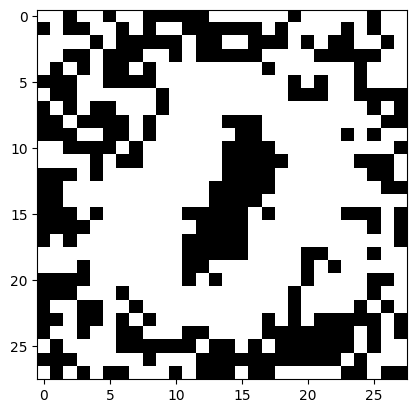

In [ ]:
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")